# ML Project phase 2 - Sarcasm detection
---


## EDA
**Understanding the structure of data set rows and columns, unique counts, missing values, dtypes, distributions, etc.**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install contractions
import contractions
import re
import nltk
import tensorflow as tf
!pip install gensim
import gensim
from nltk.corpus import stopwords

In [3]:
%config Completer.use_jedi = False

df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')
np.random.seed(0)
train_ratio = 808998/len(df)
msk = np.random.rand(len(df)) <= train_ratio

data = df[msk]
test = df[~msk]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('drive/MyDrive/Temp/sarcasm_train_set.csv')

# !cp '../content/drive/MyDrive/Kaggle/projectPhase2_dataset.zip' '/content'
# !unzip -q 'projectPhase2_dataset.zip'
# # data = pd.read_csv('drive/MyDrive/drive/MyDrive/sarcasm_train_set.csv')
# data = pd.read_csv('sarcasm_train_set.csv')

**Which means many repeated comments.**

**The output of the below cell is a data frame consisting information about each column of the data set:**

In [ ]:
def get_df_columns_info(data: pd.DataFrame):
    col_names = list(data.dtypes.index)
    col_types = list(data.dtypes)
    col_numeric = ['Numeric' if (col_types[i] == 'int64' or col_types[i] == 'float64') 
                                       else 'Non-numeric' for i in range(len(col_types))]
    python_type = []
    for i in range(len(col_types)):
        if col_types[i] == 'int64':
            python_type.append('int')
        elif col_types[i] == 'float64':
            python_type.append('float')
        elif col_types[i] == 'bool':
            python_type.append('bool')
        elif col_types[i] == 'datetime64':
            python_type.append('datetime')
        else:
            python_type.append('str or mixed')
    
    null_percentage = list(round((data.isnull().sum() / len(data)) * 100, 2))

    empty_col = ['----' for _ in range(len(col_names))]
    mean, var, min, max, unique_value_count = empty_col.copy(), empty_col.copy(), empty_col.copy(),\
                                              empty_col.copy(), empty_col.copy()
    for i in range(len(col_names)):
        if col_numeric[i] == 'Non-numeric':
            unique_value_count[i] = len(data[col_names[i]].unique())
        else:
            min[i] = data.min()[col_names[i]]
            max[i] = data.max()[col_names[i]]
            mean[i] = round(data.mean()[col_names[i]], 2)
            var[i] = round(data.var()[col_names[i]], 2)

    columns_info = pd.DataFrame({
        'Column name': col_names,
        'Column Pandas-type': col_types,
        'Column Python-type': python_type,
        'Numeric/Non-numeric': col_numeric,
        '% of null values': null_percentage,
        'Unique values count': unique_value_count,
        'Min': min, 'Max': max, 'Mean': mean, 'Variance': var
    })
    return columns_info


# cols_info = get_df_columns_info(data.head(20000))
# cols_info

In [ ]:
data.comment.isna().sum()

* **Droping rows with missing comment:**

In [4]:
data.dropna(subset=['comment'], inplace=True)

In [ ]:
data.isna().sum()

In [ ]:
data.label.value_counts()

In [ ]:
sns.countplot(data.label, palette="viridis");
plt.title('Label counts bar plot');

**Dataset is balanced.**

* **Checking number of comments in most popular subredits:**

In [ ]:
freq = data.subreddit.value_counts().sort_values(ascending=False)
freq.head(20)

In [ ]:
freq = data.subreddit.value_counts().sort_values(ascending=False)
plt.figure(figsize=(18, 7))
sns.barplot(freq.head(10).index, freq.head(10), palette="viridis")
plt.title('Number of comments in each subreddit');

In [ ]:
sub = data[['label', 'subreddit']]
idx = np.zeros(len(sub))
for subr in freq.head(10).index:
    idx = idx | (sub.subreddit == subr)
sub = sub[idx]

In [ ]:
plt.figure(figsize=(18, 7))
sns.countplot(sub.subreddit, hue=sub.label, palette="mako")
plt.title('Number of comments in each subreddit by label');

**Which subreddits have more sarcasm ratio?**

In [ ]:
ratio = data[['label', 'subreddit']].groupby('subreddit').agg([np.sum, np.mean, np.size])\
                            .sort_values(by=('label', 'size'), ascending=False)\
                            .head(10).sort_values(by=('label', 'mean'), ascending=False)[('label', 'mean')]
ratio

In [ ]:
plt.figure(figsize=(18, 7))
sns.barplot(ratio.index, ratio * 100, palette="viridis");
plt.title('Percentage of sarcastic comments in each subreddit');
plt.ylabel('Percentage');

* **Comments lengths and distributions:**

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data.comment.str.len());
plt.title('Length of comments histogram');
plt.xlabel('comment length');

In [ ]:
data.comment.str.len().sort_values(ascending=False)

**There are some comments with length 10,000!**

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(data.comment.str.len().sort_values(ascending=False));
plt.title('Box plot of comment lengths');
plt.xlabel('comment length');

In [ ]:
cl = data.comment.str.len()
len(cl[cl < 300])/len(data)

**More than 99.7 % of comments are shorter than 300 characters. Lets see distribution of them:**

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_palette("mako")
sns.distplot(cl[cl < 500]);
plt.xlabel('comment length');
plt.title('Length of comments distribution');

**Now, splitted by label:**

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_palette("viridis")
sns.distplot(cl[(data.label == 0) & (cl < 250)], label='Non-sarcastic')
sns.distplot(cl[(data.label == 1) & (cl < 250)], label='Sarcastic')
plt.xlabel('comment length');
plt.title('Length of comments distribution by label');
plt.legend();

**Parent comments intersection with main comments:**

In [ ]:
len(set(data.comment).intersection(set(data.parent_comment)))

* **Date and time distributions:**

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data.date.str[:4], hue=data.label, palette="viridis")
plt.title('comments histogram by year and label');
plt.xlabel('year');

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data.date.str[5:], hue=data.label, palette="mako")
plt.title('comments histogram by month and label');
plt.xlabel('month');

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data.created_utc.str[10:13], hue=data.label, palette="rocket")
plt.title('comments histogram by creation hour and label');
plt.xlabel('hour');

* **Scores, ups, and downs histograms by label:**


In [ ]:
s = data[['label', 'score']]
s = s[(s.score < 20) & (s.score > -10)]
sns.set_palette("Spectral")
plt.figure(figsize=(8, 6))
sns.countplot(s.score, hue=s.label);
plt.title('Scores histogram by label');
plt.xlabel('score');

In [ ]:
s = data[['label', 'ups']]
s = s[(s.ups < 20) & (s.ups > -10)]
sns.set_palette("YlOrBr")
plt.figure(figsize=(8, 6))
sns.countplot(s.ups, hue=s.label);
plt.title('ups histogram by label');
plt.xlabel('ups');

In [ ]:
s = data[['label', 'downs']]
s = s[(s.downs < 20) & (s.downs > -10)]
sns.set_palette("rocket")
plt.figure(figsize=(8, 6))
sns.countplot(s.downs, hue=s.label);
plt.title('downs histogram by label');
plt.xlabel('downs');

**Word cloud:**

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(data.loc[data['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

In [ ]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(data.loc[data['label'] == 0, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

## Preprocessing
Here we're going to make some changes in texts to make them more digestible (for example removing non ascii characters if there are any).

First let's check to see if there are any non ascii characters

In [ ]:
data['comment'].apply(lambda x : x.isascii()).all()

Looks like there aren't any!

Now we implemente  function to preprocess data.

In [5]:
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

def preprocess(data, remove_stop_words=False, remove_special=False):

    #Now let's expand contractions, for example changing "don't" to "do not".
    pre_data = data.apply(lambda x : contractions.fix(x))


    #Now we will remove special characters like dots, question marks, etc.
    if remove_special:
        pre_data = pre_data.apply(lambda x: re.sub('[^a-zA-Z0-9]+', ' ', x))

    #We are going to convert words to their base form (Lemmatization). for example convert "caring" to "care".
    lemmatizer = nltk.stem.WordNetLemmatizer()

    for pos_tag in ['v', 'n', 'a']: # v for verbs, n for nouns and a for adverbs
        pre_data = pre_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(w, pos_tag) for w in text.split()]) )

    #Now let's remove stopwords because they don't contain much  information and removing them will make our data smaller. (we have to test later)
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        pre_data = pre_data.apply(lambda text: ' '.join(word for word in text.split() if not word.lower() in stop_words))
    return pre_data

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def replace_zero_length(pre_data):
    k = np.where(pre_data.apply(lambda x: len(x) == 0))[0]
    print(len(k))
    pre_data.iloc[k] = 'None'
    return pre_data


raw_data = data['comment']
pre_data = replace_zero_length(preprocess(data['comment'], True, True))

pre_sentences = [[word for word in document.lower().split()] for document in pre_data]
raw_sentences = [[word for word in document.lower().split()] for document in raw_data]

7380


## Embedding 


* **At first we use Word2Vec model**

In [ ]:
pre_embed = gensim.models.Word2Vec(pre_sentences, vector_size=50, window=5, min_count=1)
raw_embed = gensim.models.Word2Vec(raw_sentences, vector_size=50, window=5, min_count=1, )

In [ ]:
def get_word2vec_enc(comments, embed):
    """
    get word2vec value for each word in sentence.
    concatenate words in numpy array, so we can use it as RNN input
    """
    encoded_comments = []
    for comment in comments:
        word2vec_embedding = embed.wv[comment]
        encoded_comments.append(word2vec_embedding)
    return encoded_comments
        
    
def word2vec_padding(df, embed):
    """
    encode text value to numeric value
    """
    # encode words into word2vec    
    encoded_comment = get_word2vec_enc(df,embed)
    padded_encoded_comments = tf.keras.preprocessing.sequence.pad_sequences(encoded_comment, maxlen=100, dtype="float64", padding='post')
    # encoded sentiment
    X = np.array(padded_encoded_comments)
    return X

In [ ]:
# w2v_pre_x = word2vec_padding(pre_sentences[0:10000], pre_embed)
# w2v_raw_x = word2vec_padding(raw_sentences[0:10000], raw_embed)

* **Tokenizing:**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
embedding_dim = 100
max_length = 100 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def token_seq(data):
    tokenize = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
    tokenize.fit_on_texts(data)
    word_index = tokenize.word_index

    data_seq = tokenize.texts_to_sequences(data)

    data_padded = pad_sequences(data_seq, truncating=trunc_type, padding=padding_type, maxlen=max_length)
    return data_padded


unem_pre_x = token_seq(pre_data)
unem_raw_x = token_seq(raw_data)

* **TF-IDF:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
raw_x_itf = vectorizer.fit_transform(raw_data)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
pre_x_itf = vectorizer.fit_transform(pre_data)

* **Glove**

In [7]:
!pip install glove-python-binary
from glove import Corpus, Glove

corpus_pre = Corpus() 
corpus_raw = Corpus() 

corpus_pre.fit(pre_sentences, window=5)
corpus_raw.fit(raw_sentences, window=5)

glove_pre = Glove(no_components=100)
glove_raw = Glove(no_components=100)

glove_pre.fit(corpus_pre.matrix, epochs=30, no_threads=4, verbose=False)
glove_raw.fit(corpus_raw.matrix, epochs=30, no_threads=4, verbose=False)

glove_pre.add_dictionary(corpus_pre.dictionary)
glove_raw.add_dictionary(corpus_raw.dictionary)

In [19]:
def get_glove_matrix(glove, sentences):
    return [
            [glove.word_vectors[glove.dictionary[word]] for word in sentence]
            for sentence in sentences
    ]

def glove_padding(sentences, glove):
    encoded = get_glove_matrix(glove, sentences)
    padded = tf.keras.preprocessing.sequence.pad_sequences(encoded,maxlen=100, dtype="float32")
    return np.array(padded)

def get_glove_array_by_avg(glove, sentences):
    return np.array([np.mean(
                    [glove.word_vectors[glove.dictionary[word]] for word in sentence]
                    , axis=0) for sentence in sentences])

(100, 100)

## Models

In [ ]:
import gensim
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [ ]:
y=data['label']

from sklearn.model_selection import train_test_split
raw_x_w2v_train, raw_x_w2v_val, raw_y_w2v_train, raw_y_w2v_val = train_test_split(w2v_raw_x, y[0:10000], test_size=0.2, random_state=12)
pre_x_w2v_train, pre_x_w2v_val, pre_y_w2v_train, pre_y_w2v_val = train_test_split(w2v_pre_x, y[0:10000], test_size=0.2, random_state=42)


raw_x_unem_train, raw_x_unem_val, raw_y_unem_train, raw_y_unem_val = train_test_split(unem_raw_x, y, test_size=0.2, random_state=42)
pre_x_unem_train, pre_x_unem_val, pre_y_unem_train, pre_y_unem_val = train_test_split(unem_pre_x, y, test_size=0.2, random_state=42)


raw_x_itf_train, raw_x_itf_val, raw_y_itf_train, raw_y_itf_val = train_test_split(raw_x_itf, y, test_size=0.2, random_state=42)
pre_x_itf_train, pre_x_itf_val, pre_y_itf_train, pre_y_itf_val = train_test_split(pre_x_itf ,y, test_size=0.2, random_state=42)


* **Logistic Regression:**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
y=data['label']

X = np.vstack([mat.reshape(100 * 100) for mat in w2v_raw_x])
x_train, x_val, y_train, y_val = train_test_split(X, y[:10000], test_size=0.2, random_state=12)
clf = LogisticRegression()
clf.fit(x_train, y_train)
pred = clf.predict(x_val)
print('Accuracy score: ', met.accuracy_score(pred, y_val))
print('F1 score:       ', met.f1_score(pred, y_val))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(raw_x_itf, y, test_size=0.2, random_state=8)
clf.fit(x_train, y_train)
pred = clf.predict(x_val)
print('Accuracy score: ', met.accuracy_score(pred, y_val))
print('F1 score:       ', met.f1_score(pred, y_val))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
def LSTM_without_embed(x_train,y_train,x_test,y_test):
  with tf.device('/device:GPU:0'):
    model = tf.keras.Sequential([
          tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences = True)),
          tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(32)),
          tf.keras.layers.Dense(1, activation='sigmoid')])
    opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)



In [ ]:
LSTM_without_embed(raw_x_w2v_train,raw_y_w2v_train, raw_x_w2v_val, raw_y_w2v_val)

In [ ]:
LSTM_without_embed(pre_x_w2v_train,pre_y_w2v_train, pre_x_w2v_val, pre_y_w2v_val)

---

* **Custom deep neural network:**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt
import sys
!pip install colorama
import colorama
from collections import OrderedDict
from matplotlib import pyplot as plt 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=3)
import os
import sklearn.metrics as met


In [ ]:
# dset = []
# for i, mat in enumerate(w2v_raw_x):
#     t = torch.from_numpy(mat)
#     dset.append((t, y[i]))

In [ ]:
# len(dset)

In [24]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, embed, sentences, labels):
        self.embed = embed
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        vec = glove_padding([self.sentences[idx]], self.embed)[0]
        return torch.from_numpy(vec), self.labels.iloc[idx]

y=data['label']
train_data = CustomDataset(glove_pre, pre_sentences, y)

In [25]:
from torch.utils.data import DataLoader

def sampler(dataset):
    return SubsetRandomSampler(np.random.choice(np.array(list(range(len(dataset)))),\
                                                    size=len(dataset), replace=False))

def loader(dataset, sampler=None):
    samp = None
    if sampler is not None:
        samp = sampler
    else:
        samp = sampler(dataset)
    return DataLoader(dataset, 
                      batch_size = batch_size,
                      sampler = samp,
                      num_workers = num_workers,
                      )


val_size = 0.15
num_workers = 4
batch_size = 512

# creating train and validation data samples:
num = len(train_data)
sp = int(val_size * num)
ind = list(range(num))
np.random.shuffle(ind)
val_ind, train_ind = ind[:sp], ind[sp:]
train_samp, val_samp = SubsetRandomSampler(train_ind), SubsetRandomSampler(val_ind)

# creating data loaders:
train_loader = loader(train_data, train_samp)
val_loader = loader(train_data, val_samp)

In [26]:
next(iter(train_loader))[0].shape

torch.Size([512, 100, 100])

In [ ]:
class N_net(nn.Module):
    def __init__(self, input_matrix_dim=50):
        super(N_net, self).__init__()
        self.fc1 = nn.Linear(in_features=10000, out_features=10000)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.bnorm = nn.BatchNorm1d(num_features=10000)
        self.fc2 = nn.Linear(in_features=10000, out_features=2)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.fc1(out)
        # out = self.bnorm(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.softmax(out)
        return out

In [ ]:
nn_model = N_net()

In [ ]:
test_input = torch.randn(128, 100, 100) 
out = nn_model(test_input)
print("out.shape: \n%s" % (out.shape,))

In [60]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import gc
test_acc_all, train_acc_all, val_acc_all, train_loss_all = [], [], [], []
acc_all, f1_all, prec_all, rec_all = [], [], [], []

def train_cnn(model, train_loader, test_loader, val_loader, device, num_epochs, lr=1e-4, print_every=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    blocks, best_acc = 0, 0
    for epoch in range(num_epochs):
        print("=" * 25, "Starting epoch %d" % (epoch + 1), "=" * 25)
        names = ['train_loader']
        for d_idx, dataloader in enumerate([train_loader]):
            for batch_idx, (data, labels) in enumerate(dataloader):
                model.train()
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[:, 1].to(torch.float64), labels.to(torch.float64))
                loss.backward()
                optimizer.step()
                if batch_idx % print_every == 0 :
                    print("\nstarting batch %d/%d, Loss=%.4f" % (batch_idx, len(dataloader), loss.item()), end=' ')
                    print('on: ', names[d_idx])
                    train_acc = accuracy(model, train_loader, device)
                    val_acc = accuracy(model, val_loader, device)
#                     test_acc = accuracy(model, test_loader, device)
                    test_acc, f1, prec, rec = score(model, test_loader, device)
                    acc_all.append(test_acc); f1_all.append(f1); prec_all.append(prec); rec_all.append(rec);
                    if val_acc > best_acc:
                        torch.save(model.state_dict(), 'model.pt')
                        best_acc = val_acc
                    print(colorama.Fore.GREEN, "Accuracy on training: %.2f%%" % (100*train_acc))
                    print("Accuracy on val: %.2f%%" % (100*val_acc), colorama.Fore.RESET)                
#                     print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET) 
#                     print(f'F1 score on test : {100*f1:.2f}')
#                     print(f'Precision score on test : {100*prec:.2f}')
#                     print(f'Recall score on test : {100*rec:.2f}', colorama.Fore.RESET)
                    test_acc_all.append(test_acc); train_acc_all.append(train_acc); val_acc_all.append(val_acc); train_loss_all.append(loss.item());
                    blocks += 1
        
        plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks)
        plot_scores(acc_all, f1_all, prec_all, rec_all, blocks)
        gc.collect()
        scheduler.step()
#         if (epoch+1) % 3 == 0:
#             plot_scores(acc_all, f1_all, prec_all, rec_all, epoch=epoch+1)
            

In [53]:
def accuracy(model, dataloader, device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data).max(1)[1]
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
    return num_correct / num_samples

def print_score(y_test, pred):
    print('Accuracy:  ', met.accuracy_score(y_test, pred))
    print('F1_score:  ', met.f1_score(y_test, pred))
    print('Precision: ', met.precision_score(y_test, pred))
    print('Recall:    ', met.recall_score(y_test, pred))
    
def score(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    print_score(y_test, pred)
    return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
    met.precision_score(y_test, pred),\
    met.recall_score(y_test, pred)

def plot_conmat(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    c = met.confusion_matrix(y_test, pred)
    disp = met.ConfusionMatrixDisplay(c)
    plt.figure(figsize=(10, 6))
    disp.plot()

In [54]:
def plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks):
    plt.figure(figsize=(10, 6))
#     print(blocks)
#     print(len(train_acc_all))
    x = np.arange(blocks)
    plt.plot(x, train_acc_all, label='train accuracy');
    plt.plot(x, val_acc_all, label='validation accuracy');
#     plt.plot(x, test_acc_all, label='test accuracy');
#     plt.plot(reg, mean_f1, label='F1_score');
    plt.xlabel('Batch training blocks');
    plt.ylabel('Model accuracy');
    plt.title('Model prediction accuracy by training batches');
    plt.legend();
    plt.show();
    
def plot_scores(acc_all, f1_all, prec_all, rec_all, epoch):
    plt.figure(figsize=(10, 6))
    x = np.arange(epoch)
    plt.plot(x, acc_all, label=' accuracy');
    plt.plot(x, f1_all, label=' F1 score');
    plt.plot(x, prec_all, label=' precision');
    plt.plot(x, rec_all, label='recall');
    plt.xlabel('Batch training blocks');
    plt.ylabel('Model scores');
    plt.title('Model prediction scores on test data by training epochs');
    plt.legend();
    plt.show();

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
Nn_model = nn_model.to(device)

train_cnn(nn_model.double(), train_loader, val_loader, val_loader, device, num_epochs=10, lr=1e-5, print_every=1000)

In [56]:
class Net3(nn.Module):
    def __init__(self,  dropout_rate=0):
        super(Net3, self).__init__()
        channels = 4
        kernels = [2, 3, 4, 5]
        self.c1 = nn.Conv1d(100, channels, kernel_size=kernels[0])
        self.c2 = nn.Conv1d(100, channels, kernel_size=kernels[1])
        self.c3 = nn.Conv1d(100, channels, kernel_size=kernels[2])
        self.c4 = nn.Conv1d(100, channels, kernel_size=kernels[3])

        self.p1 = nn.MaxPool1d(kernels[0])
        self.p2 = nn.MaxPool1d(kernels[1])
        self.p3 = nn.MaxPool1d(kernels[2])
        self.p4 = nn.MaxPool1d(kernels[3])

        linear_features = channels*(sum(self.cal_out_size(i, word_size=100) for i in kernels))
        self.f = nn.Linear(linear_features, 2)

        self.dropout = nn.Dropout(0.25)


    def cal_out_size(self, kernel_size, stride=1, word_size=100):
        out_size = ((word_size - (kernel_size - 1) - 1) / stride) + 1 # output size of conv
        out_size = np.floor(out_size)
        out_size = ((out_size - 1 * (kernel_size - 1) - 1) / kernel_size) + 1 #output size of pool
        out_size = np.floor(out_size)
        return int(out_size)

    def forward(self, x):
        y1 = self.c1(x)
        y1 = F.relu(y1)
        y1 = self.p1(y1)

        y2 = self.c2(x)
        y2 = F.relu(y2)
        y2 = self.p2(y2)

        y3 = self.c3(x)
        y3 = F.relu(y3)
        y3 = self.p3(y3)

        y4 = self.c4(x)
        y4 = F.relu(y4)
        y4 = self.p4(y4)

        out = torch.cat((y1, y2, y3, y4), 2)
        out = out.reshape(out.size(0), -1)

        out = self.f(out)
        out = self.dropout(out)
        out = F.softmax(out)

        return out


========================= Starting epoch 1 =========================

starting batch 0/1343, Loss=0.6931 on:  train_loader
Accuracy:   0.5165512122711529
F1_score:   0.6609682325793896
Precision:  0.5099272743497077
Recall:     0.9391434393899553
 Accuracy on training: 51.38%
Accuracy on val: 51.66% 

starting batch 700/1343, Loss=0.6817 on:  train_loader
Accuracy:   0.5762576282368465
F1_score:   0.5545431689914955
Precision:  0.5868332691143282
Recall:     0.5256212200894032
 Accuracy on training: 57.46%
Accuracy on val: 57.63% 


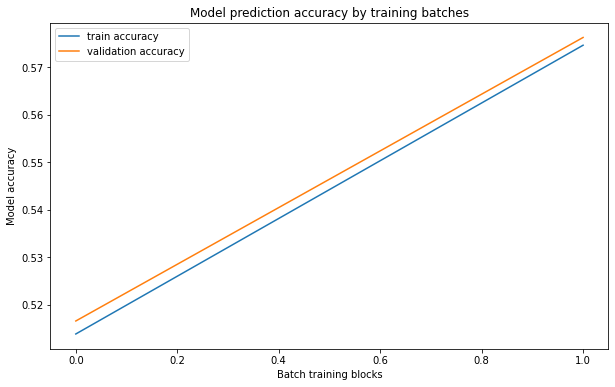

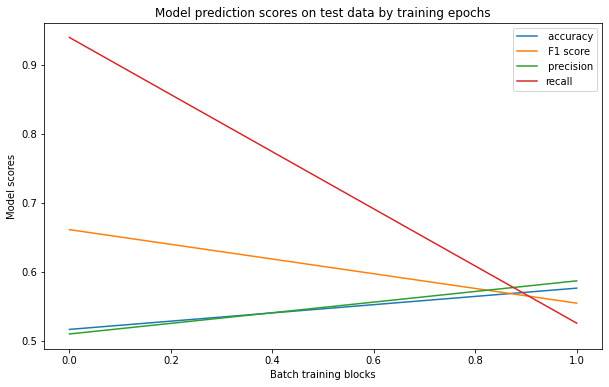

========================= Starting epoch 2 =========================

starting batch 0/1343, Loss=0.6733 on:  train_loader
Accuracy:   0.6101682335477486
F1_score:   0.5775791966400072
Precision:  0.6329592416319016
Recall:     0.5311103076518539
 Accuracy on training: 60.87%
Accuracy on val: 61.02% 

starting batch 700/1343, Loss=0.6622 on:  train_loader
Accuracy:   0.6203282203529605
F1_score:   0.5969940213062089
Precision:  0.6386844224682062
Recall:     0.5604128319747568
 Accuracy on training: 61.93%
Accuracy on val: 62.03% 


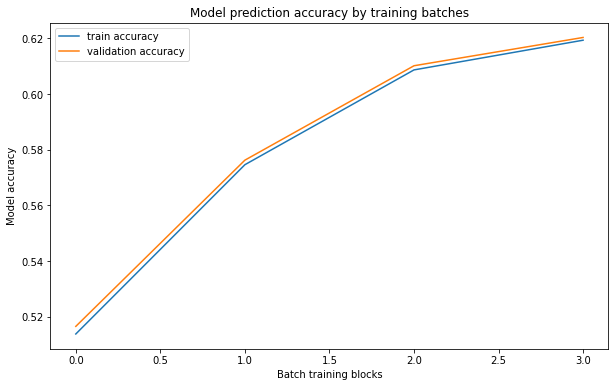

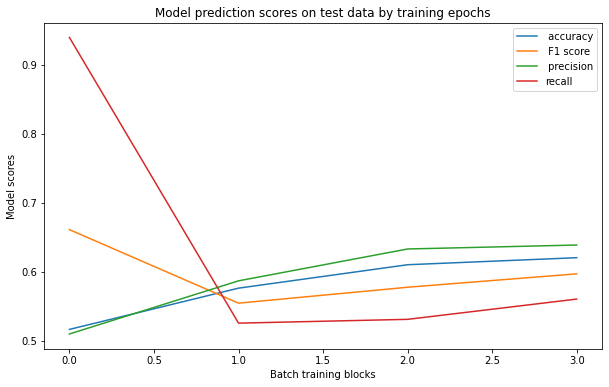

========================= Starting epoch 3 =========================

starting batch 0/1343, Loss=0.6471 on:  train_loader
Accuracy:   0.6254247072406399
F1_score:   0.5938788100964764
Precision:  0.6512658600200028
Recall:     0.5457862214041547
 Accuracy on training: 62.39%
Accuracy on val: 62.54% 

starting batch 700/1343, Loss=0.6367 on:  train_loader
Accuracy:   0.628698664027709
F1_score:   0.6101075529538094
Precision:  0.6448288486179755
Recall:     0.578934393899553
 Accuracy on training: 62.77%
Accuracy on val: 62.87% 


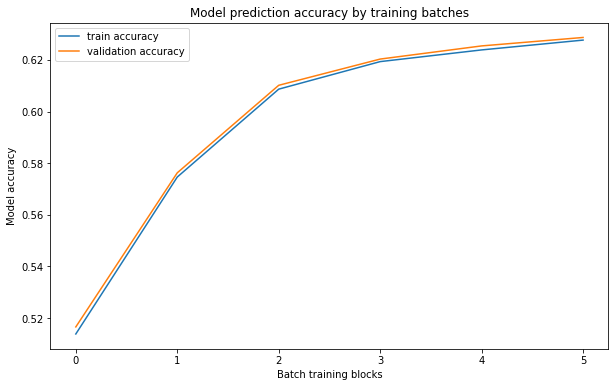

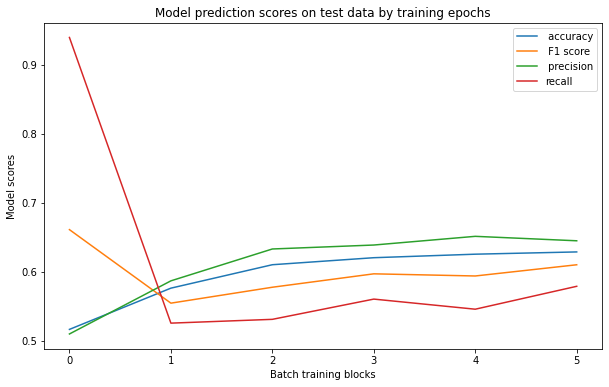

========================= Starting epoch 4 =========================

starting batch 0/1343, Loss=0.6274 on:  train_loader
Accuracy:   0.6304222332178789
F1_score:   0.6164970861822568
Precision:  0.643128782874181
Recall:     0.591983302655798
 Accuracy on training: 62.90%
Accuracy on val: 63.04% 

starting batch 700/1343, Loss=0.6393 on:  train_loader
Accuracy:   0.6324014514266865
F1_score:   0.6060016794095548
Precision:  0.6556122936867672
Recall:     0.5633710228766763
 Accuracy on training: 63.13%
Accuracy on val: 63.24% 


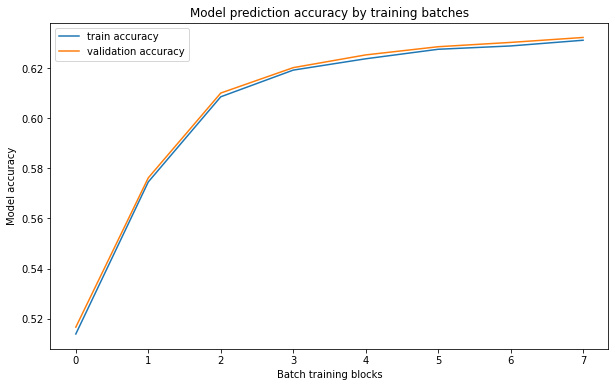

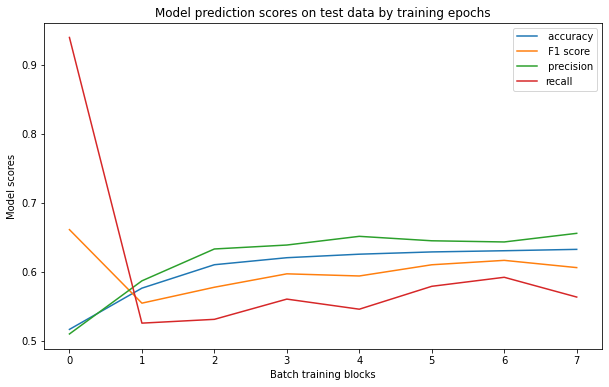

========================= Starting epoch 5 =========================

starting batch 0/1343, Loss=0.6582 on:  train_loader
Accuracy:   0.6333910605310902
F1_score:   0.6133574540995156
Precision:  0.6514252988231817
Recall:     0.5794931632921377
 Accuracy on training: 63.28%
Accuracy on val: 63.34% 

starting batch 700/1343, Loss=0.6286 on:  train_loader
Accuracy:   0.6346610588817417
F1_score:   0.6090041746467437
Precision:  0.6577256696215804
Recall:     0.5670030239284776
 Accuracy on training: 63.38%
Accuracy on val: 63.47% 


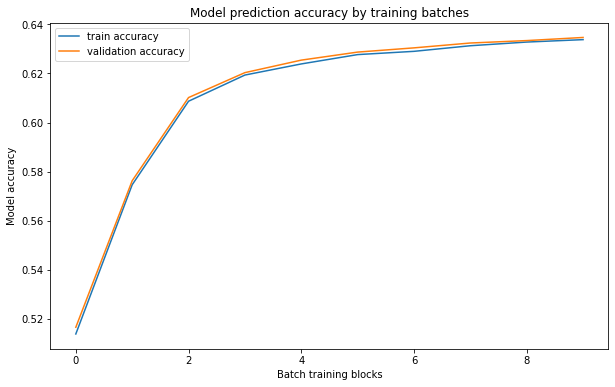

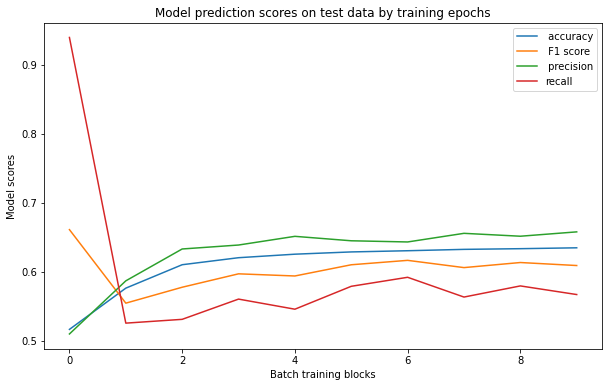

========================= Starting epoch 6 =========================

starting batch 0/1343, Loss=0.6428 on:  train_loader
Accuracy:   0.6351641101764803
F1_score:   0.611963862819051
Precision:  0.6562017982769648
Recall:     0.5733138311859058
 Accuracy on training: 63.44%
Accuracy on val: 63.52% 

starting batch 700/1343, Loss=0.6481 on:  train_loader
Accuracy:   0.6361784595084942
F1_score:   0.6188102129865641
Precision:  0.6524131397234317
Recall:     0.5884992111490929
 Accuracy on training: 63.47%
Accuracy on val: 63.62% 


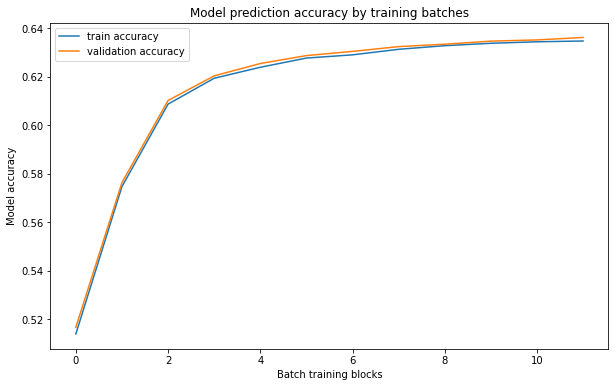

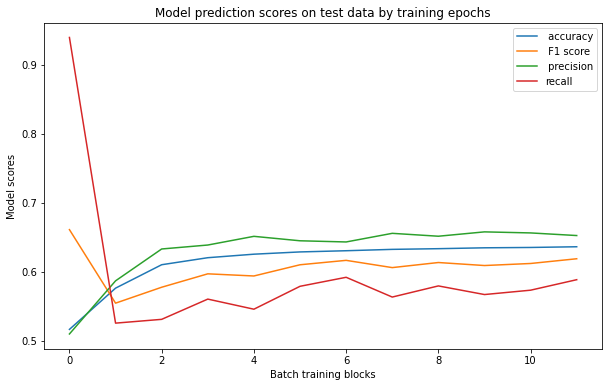

========================= Starting epoch 7 =========================

starting batch 0/1343, Loss=0.6502 on:  train_loader
Accuracy:   0.6377618340755402
F1_score:   0.6216330292615276
Precision:  0.6531687272595623
Recall:     0.5930022350775703
 Accuracy on training: 63.63%
Accuracy on val: 63.78% 

starting batch 700/1343, Loss=0.6184 on:  train_loader
Accuracy:   0.6385700148441366
F1_score:   0.6164979305396348
Precision:  0.6592742312802949
Recall:     0.578934393899553
 Accuracy on training: 63.73%
Accuracy on val: 63.86% 


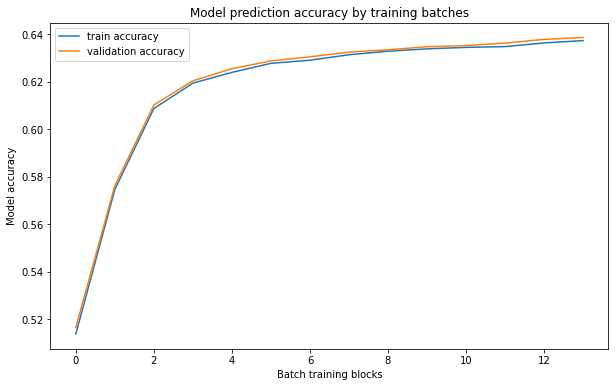

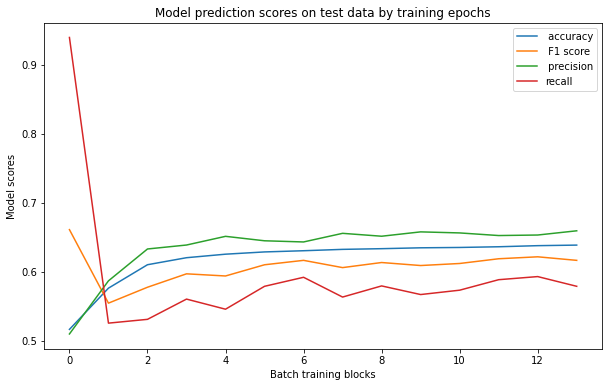

========================= Starting epoch 8 =========================

starting batch 0/1343, Loss=0.6288 on:  train_loader
Accuracy:   0.6386277420418934
F1_score:   0.6238497459140228
Precision:  0.6529974123059229
Recall:     0.5971930055219563
 Accuracy on training: 63.74%
Accuracy on val: 63.86% 

starting batch 700/1343, Loss=0.6407 on:  train_loader
Accuracy:   0.6388421573478476
F1_score:   0.6183263321190149
Precision:  0.6582179834489925
Recall:     0.5829936891927425
 Accuracy on training: 63.83%
Accuracy on val: 63.88% 


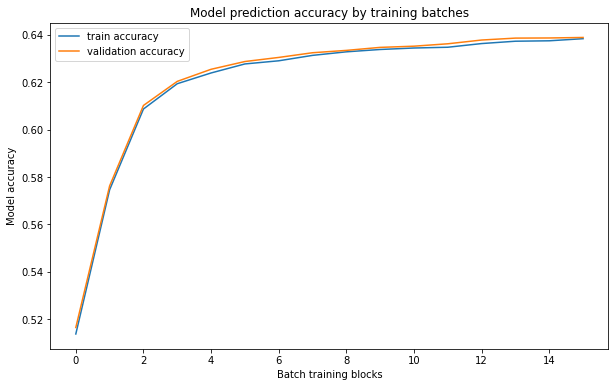

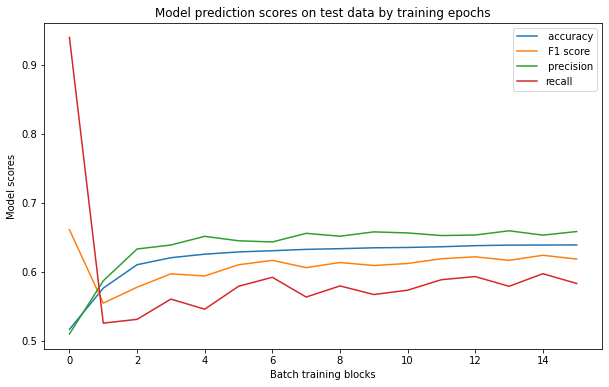

========================= Starting epoch 9 =========================

starting batch 0/1343, Loss=0.6295 on:  train_loader
Accuracy:   0.6394689097806366
F1_score:   0.6141326413528924
Precision:  0.663298379408961
Recall:     0.5717525637654484
 Accuracy on training: 63.90%
Accuracy on val: 63.95% 

starting batch 700/1343, Loss=0.6306 on:  train_loader
Accuracy:   0.6396668316015174
F1_score:   0.6163693193790827
Precision:  0.6616837581058664
Recall:     0.5768636602682093
 Accuracy on training: 63.91%
Accuracy on val: 63.97% 


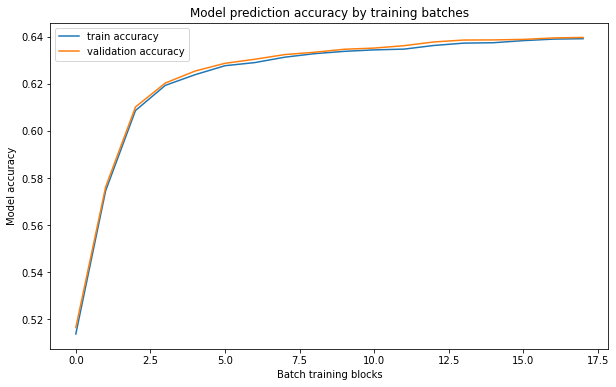

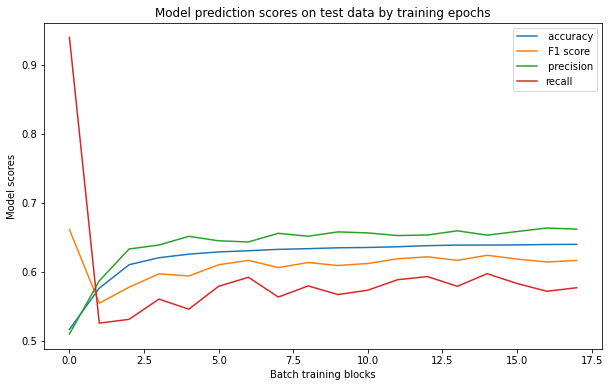

========================= Starting epoch 10 =========================

starting batch 0/1343, Loss=0.6265 on:  train_loader
Accuracy:   0.6401533894111826
F1_score:   0.6172267691255032
Precision:  0.6619315509228771
Recall:     0.5781784117801736
 Accuracy on training: 63.92%
Accuracy on val: 64.02% 

starting batch 700/1343, Loss=0.6338 on:  train_loader
Accuracy:   0.6404337786574303
F1_score:   0.6162660728901719
Precision:  0.6634012316437707
Recall:     0.5753845648172495
 Accuracy on training: 63.94%
Accuracy on val: 64.04% 


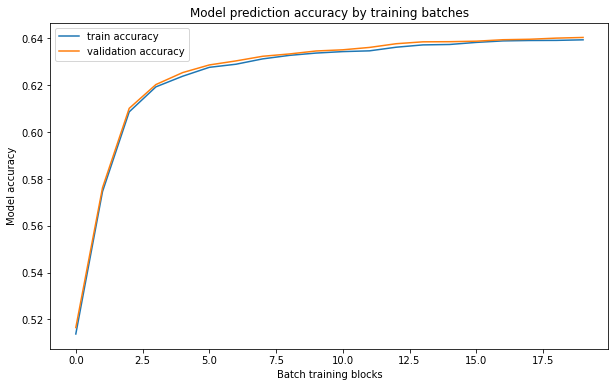

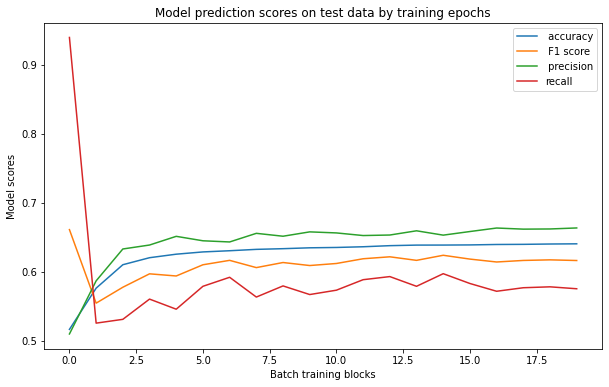

In [61]:
net3_model = Net3().to(device)

train_cnn(net3_model, train_loader, val_loader, val_loader, device, num_epochs=10, lr=1e-4, print_every=700)